## Downloading data

In [1]:
! wget "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"

--2021-06-28 16:15:58--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  35.4MB/s    in 22s     

2021-06-28 16:16:21 (34.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [2]:
! wget "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

--2021-06-28 16:16:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  17.9MB/s    in 1.0s    

2021-06-28 16:16:22 (17.9 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



## Extraing files

In [3]:
!tar -xvf "/content/annotations.tar.gz"
!tar -xvf "/content/images.tar.gz"

Streaming output truncated to the last 5000 lines.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2


H = 256
W = 256
batch_size = 8

BASE_PATH = '/content/annotations'
TRAINVAL_PATH = 'trainval.txt'
TEST_PATH = 'test.txt'

## Load Datapath

In [5]:
def load_data(base_path, tainval_path, test_path):
    df_trainval = pd.read_csv(os.path.join(base_path, tainval_path), sep=' ', header = None)
    df_test = pd.read_csv(os.path.join(base_path, test_path), sep=' ', header = None)
    
    img_path_train = [os.path.join('/content/images', name) + '.jpg' for name in df_trainval[0]]
    img_path_test = [os.path.join('/content/images', name) + '.jpg' for name in df_test[0]]
    
    mask_path_train = [os.path.join(base_path, 'trimaps', name) + '.png' for name in df_trainval[0]]
    mask_path_test = [os.path.join(base_path, 'trimaps', name) + '.png' for name in df_test[0]]
    
    return (img_path_train, mask_path_train), (img_path_test, mask_path_test)
    
(X, Y), (x_test, y_test) = load_data(BASE_PATH, TRAINVAL_PATH, TEST_PATH)

In [6]:
X = X + x_test
Y = Y + y_test

## Train-Val-Test split

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [8]:
print('Number of datapoints in training data:', len(x_train))
print('Number of datapoints in validation data:', len(x_val))

Number of datapoints in training data: 5879
Number of datapoints in validation data: 1470


## TF Data Generator

In [9]:
def preprocess(x, y):

    # process image
    image = tf.io.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [H, W])
    
    # process mask
    mask = tf.io.read_file(y)
    mask = tf.io.decode_png(mask, channels=1, dtype=tf.dtypes.uint8)
    mask = mask - 1
    mask = tf.image.resize(mask, [H, W]) 
    mask = tf.reshape(mask, (H, W))
    mask = tf.cast(mask, tf.int32)
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])

    return image, mask

In [10]:

def tf_dataset(x, y, batch_size=8):
    
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    
    return dataset

In [11]:
train_datagen = tf_dataset(x_train, y_train, batch_size = batch_size)
val_datagen = tf_dataset(x_val, y_val, batch_size = batch_size)

## Build Model

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [13]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     print(model.summary())


    return model


In [14]:
model = unet()

In [15]:
epochs = 20

train_steps = len(x_train)/batch_size
valid_steps = len(x_val)/batch_size



callbacks = [
            ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
            EarlyStopping(monitor="val_loss", patience=5, verbose=1)
            ]


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train Model

In [17]:
model.fit(train_datagen,
          steps_per_epoch=train_steps,
          validation_data=val_datagen,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
         )

Epoch 1/20
734/734 [==============================] - 526s 658ms/step - loss: 0.4002 - accuracy: 0.7328 - val_loss: 0.3434 - val_accuracy: 0.7876
Epoch 2/20
734/734 [==============================] - 468s 637ms/step - loss: 0.2894 - accuracy: 0.8170 - val_loss: 0.2847 - val_accuracy: 0.8201
Epoch 3/20
734/734 [==============================] - 468s 637ms/step - loss: 0.2488 - accuracy: 0.8446 - val_loss: 0.2354 - val_accuracy: 0.8505
Epoch 4/20
734/734 [==============================] - 468s 637ms/step - loss: 0.2230 - accuracy: 0.8613 - val_loss: 0.2338 - val_accuracy: 0.8539
Epoch 5/20
734/734 [==============================] - 468s 637ms/step - loss: 0.2087 - accuracy: 0.8710 - val_loss: 0.2137 - val_accuracy: 0.8719
Epoch 6/20
734/734 [==============================] - 467s 636ms/step - loss: 0.1921 - accuracy: 0.8818 - val_loss: 0.1922 - val_accuracy: 0.8809
Epoch 7/20
734/734 [==============================] - 467s 636ms/step - loss: 0.1808 - accuracy: 0.8894 - val_loss: 0.1895 -

In [20]:
model.save('seg_model_c.hdf5')
model.save('seg_model_c.h5')

In [21]:
test_datagen = tf_dataset(x_test, y_test, batch_size = 1)

In [22]:
test_steps = len(x_test)/batch_size
model.evaluate(test_datagen, steps = test_steps)

458/458 [==============================] - 15s 29ms/step - loss: 0.1067 - accuracy: 0.9387


[0.10671999305486679, 0.9386602640151978]

In [23]:

def display_result(real, pred):
  line = np.ones((1, 256, 3, 3))
  comp = np.concatenate([real, line, pred], axis = 2)
  p = np.argmax(comp, axis=-1)
  p = p * (255/3)
  p = p.astype(np.int32)
  plt.imshow(p[0, :, :])
  plt.show()

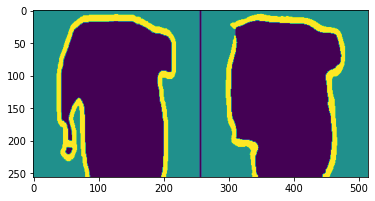

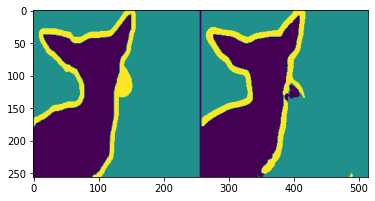

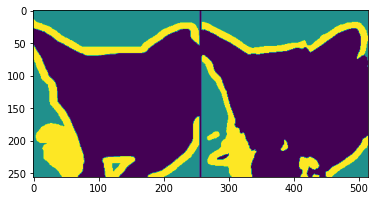

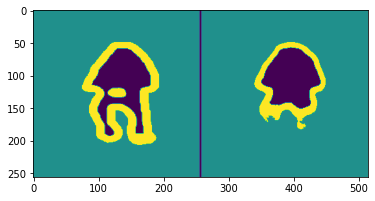

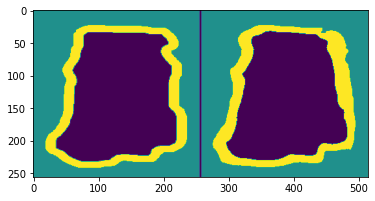

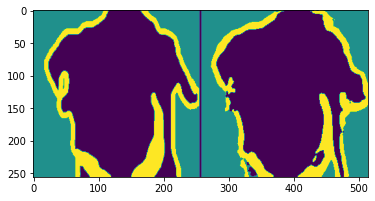

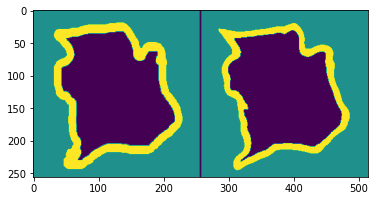

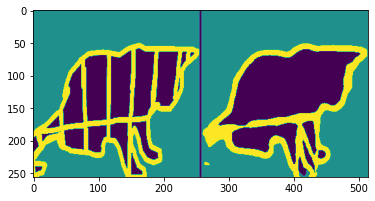

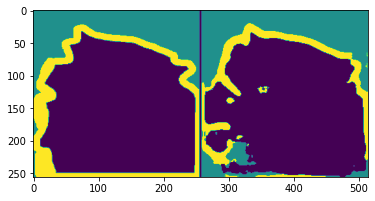

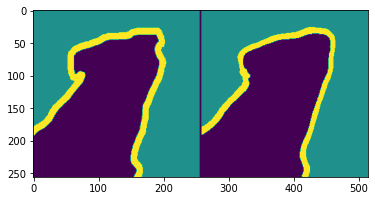

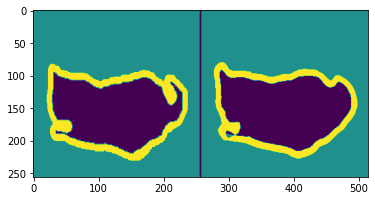

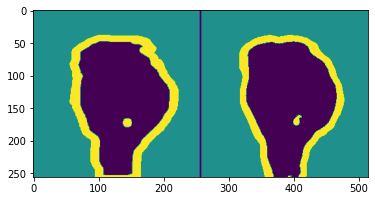

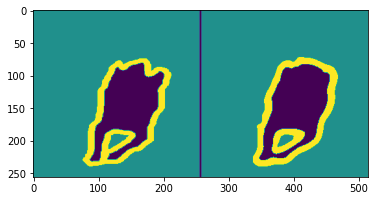

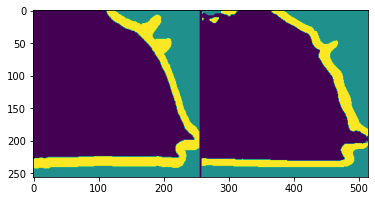

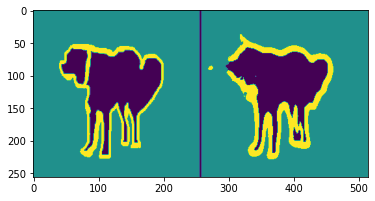

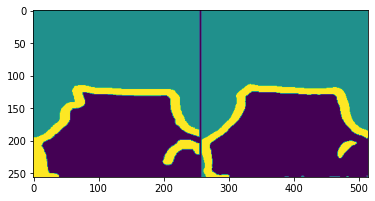

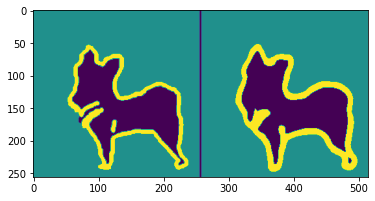

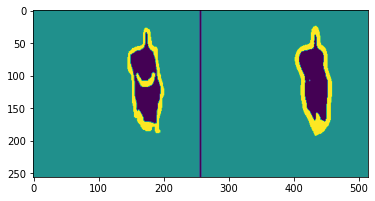

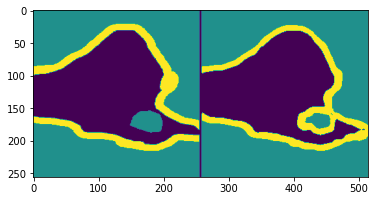

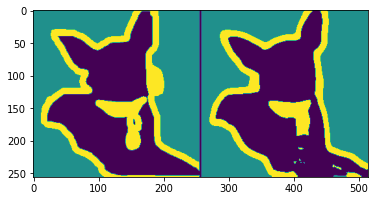

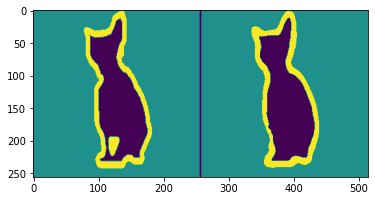

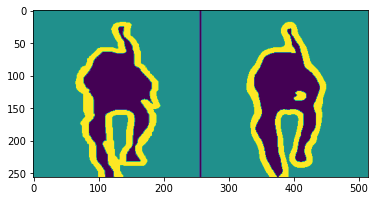

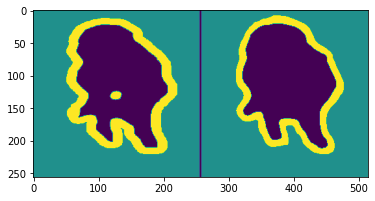

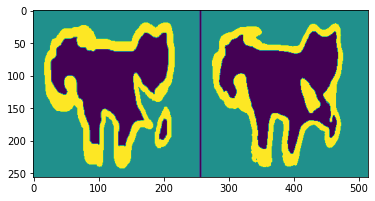

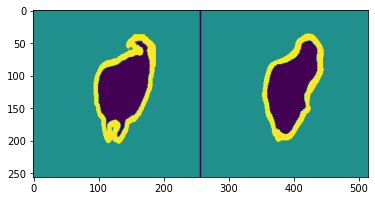

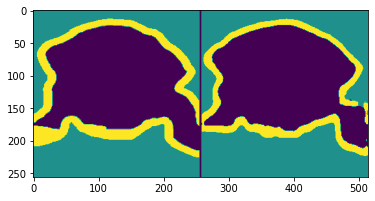

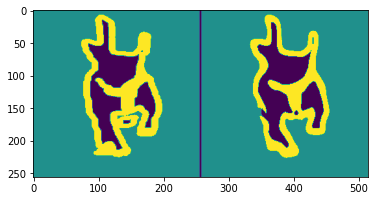

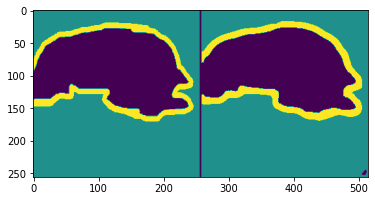

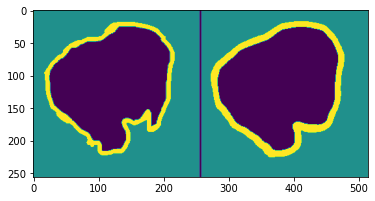

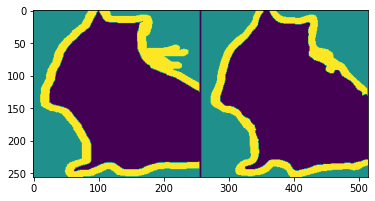

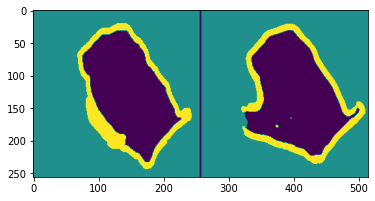

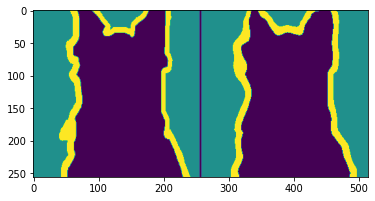

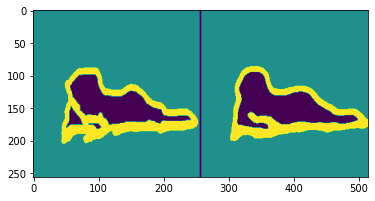

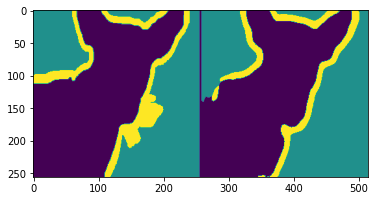

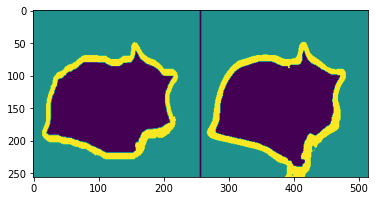

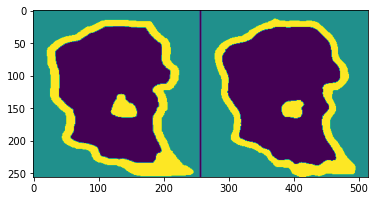

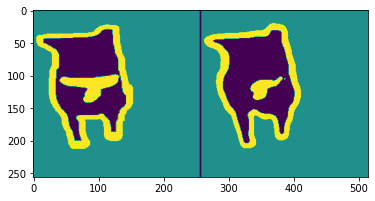

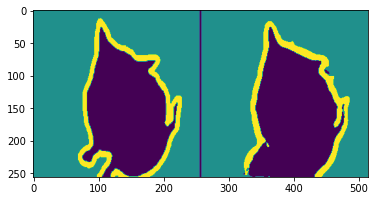

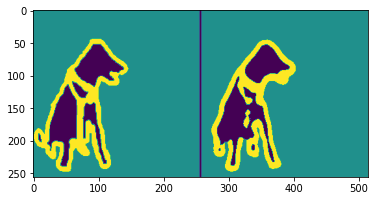

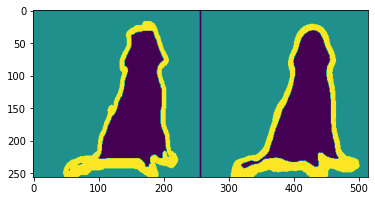

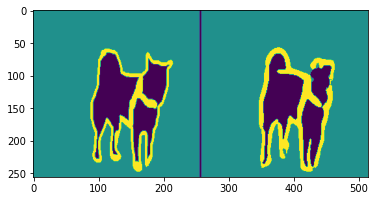

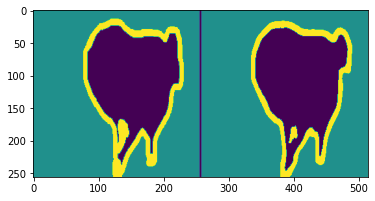

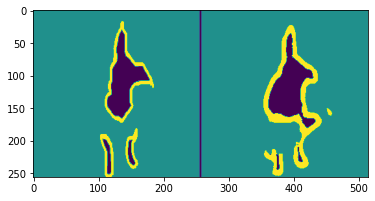

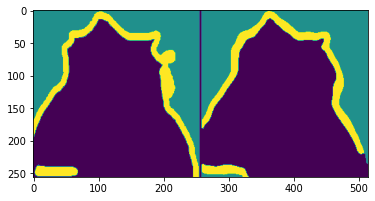

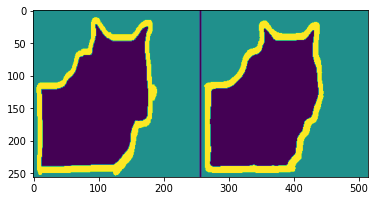

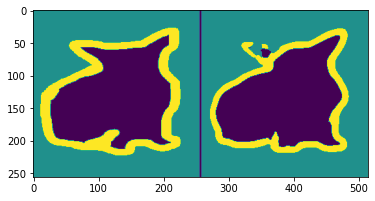

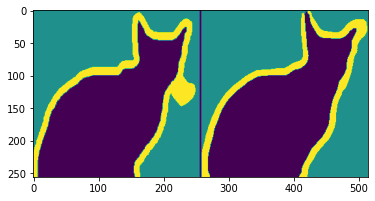

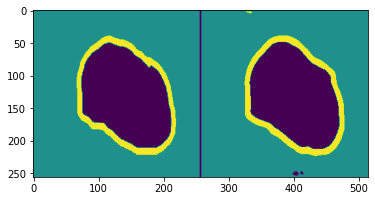

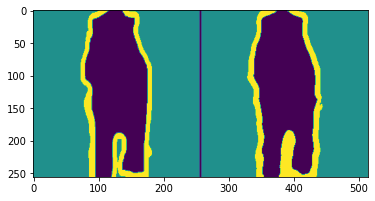

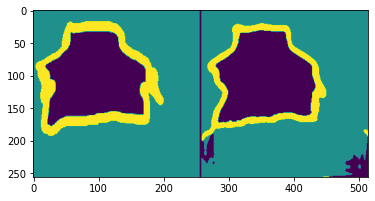

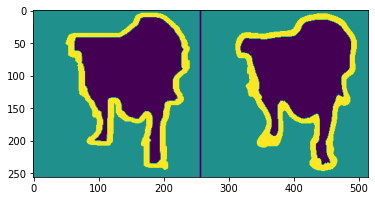

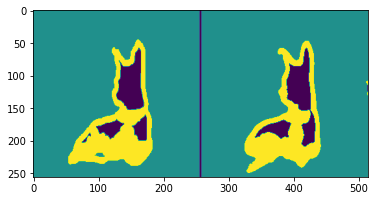

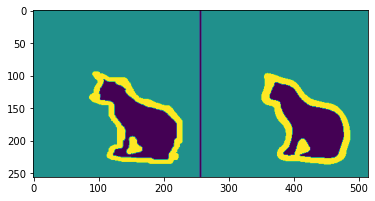

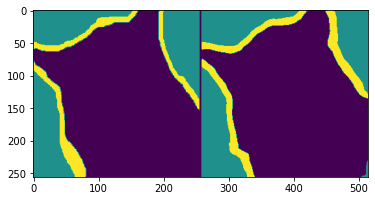

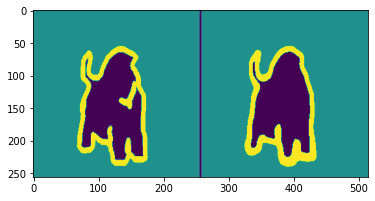

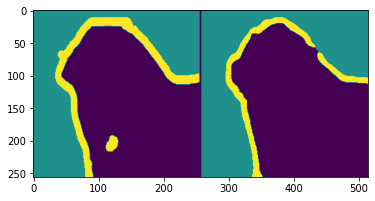

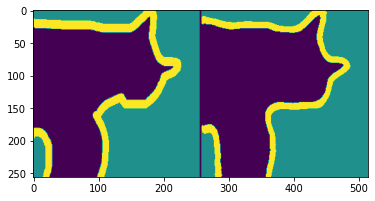

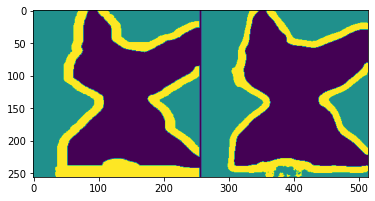

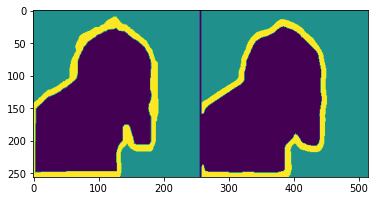

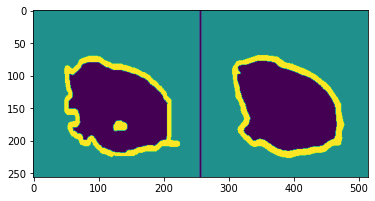

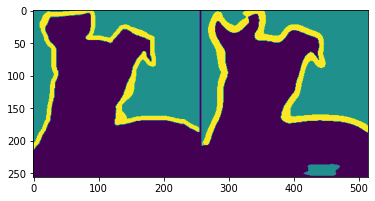

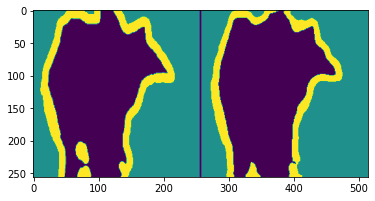

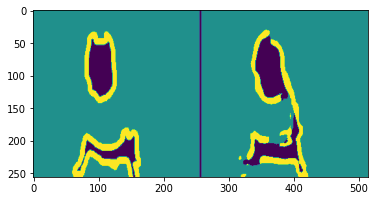

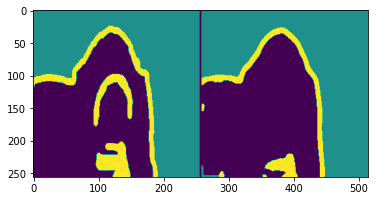

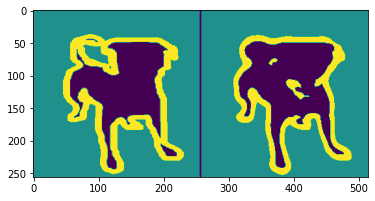

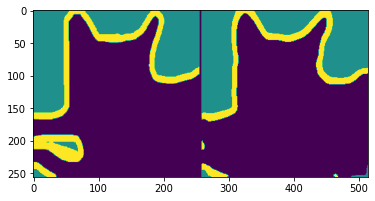

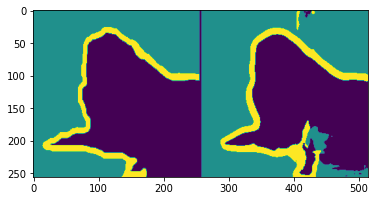

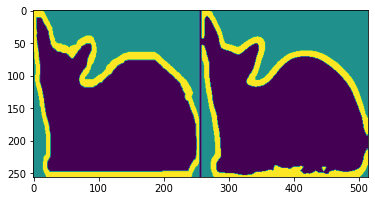

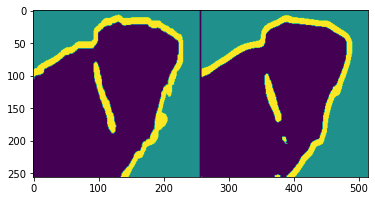

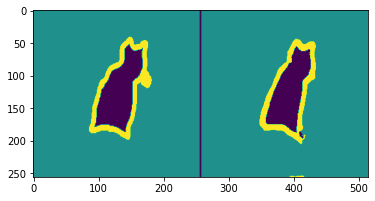

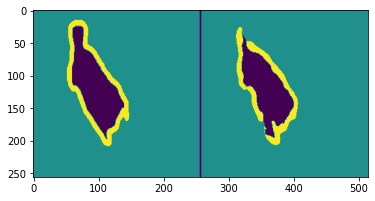

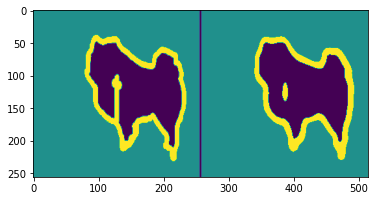

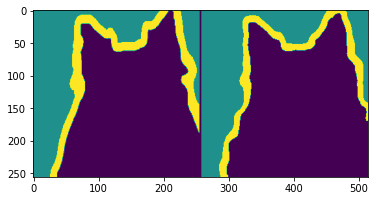

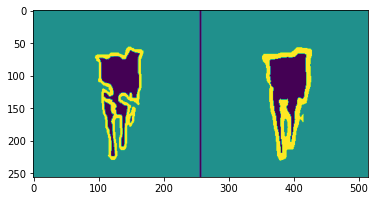

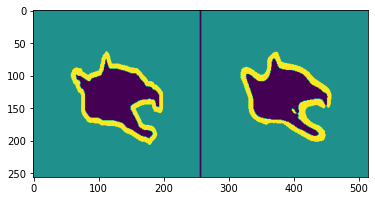

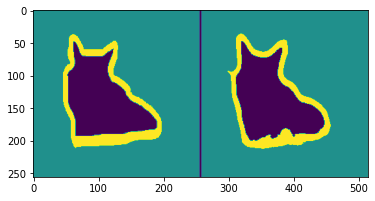

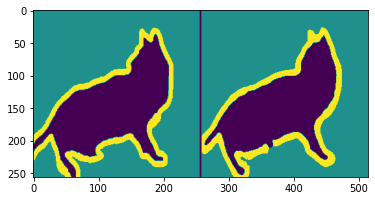

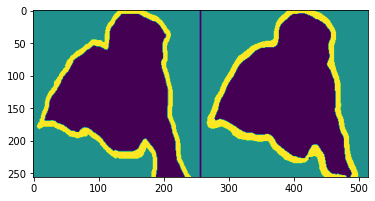

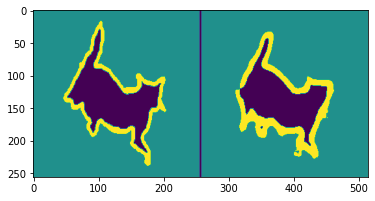

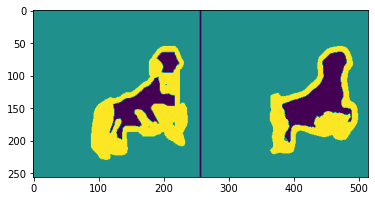

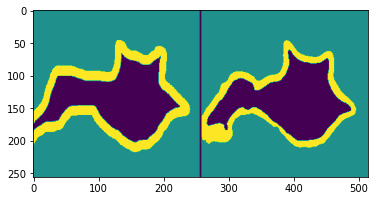

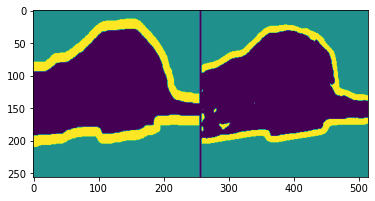

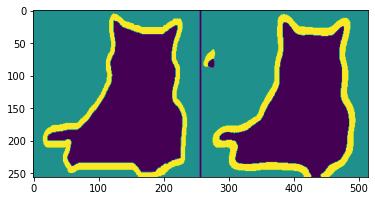

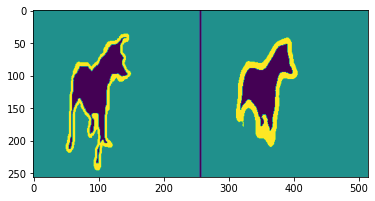

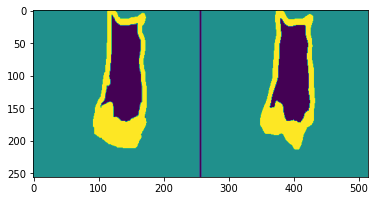

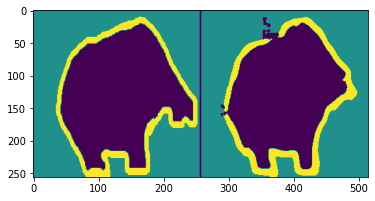

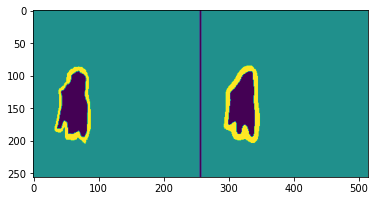

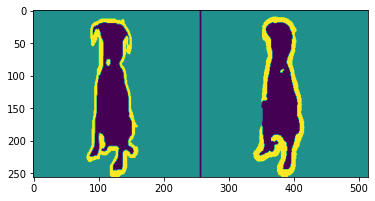

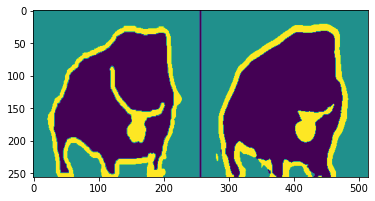

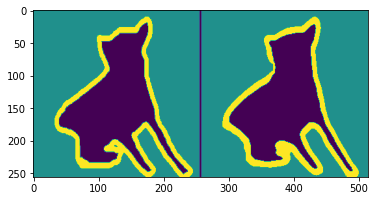

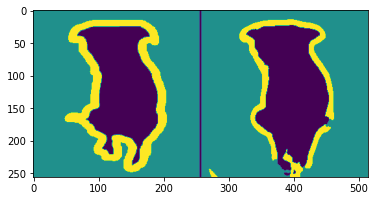

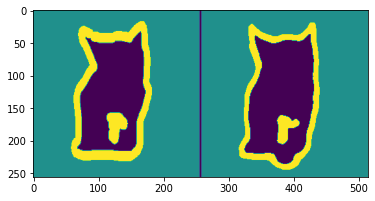

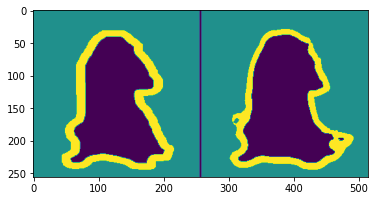

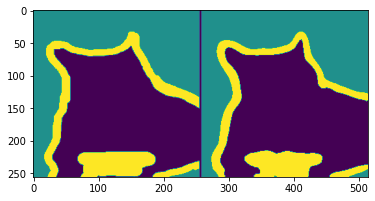

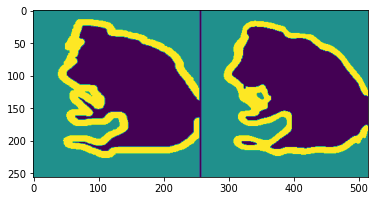

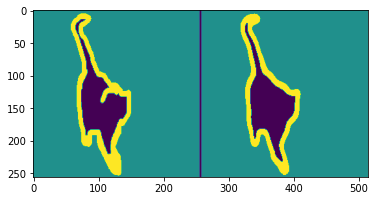

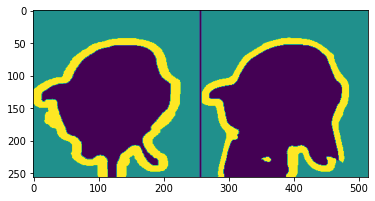

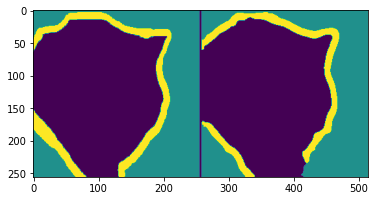

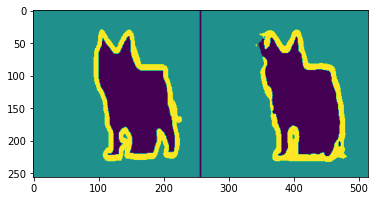

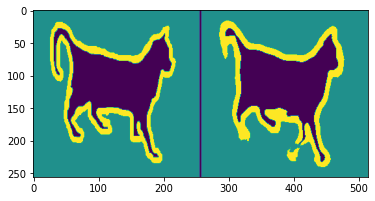

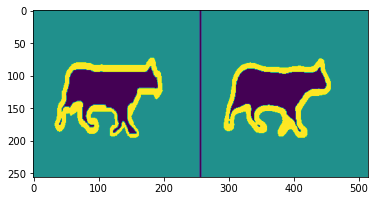

In [25]:
import matplotlib.pyplot as plt

for i, batch in enumerate(test_datagen):
  pred = model.predict(batch[0])
  real = batch[1]
  display_result(real, pred)
  if i==100:
    break
  

In [ ]:
for x, y in zip(x_test, y_test):

  filename = x.split('/')[-1]

  img, mask = preprocess(x, y)
  
  img = tf.reshape(img, (1, H, W, -1))
  pred = model.predict(img)

  print(pred.shape, mask.shape)


  
  break

(1, 256, 256, 3) (256, 256, 3)
